# **Tutorial: Random Forests**
### By Kostas Hatalis

**Prerequisite Notebooks:** *Decision Trees, Ensemble Learning, Bagging*

___
## **Bagging Decision Trees**

Bagging, also known as bootstrap aggregation, is an ensemble method involving training the same base learning algorithm such as decision trees many times using different data subsets sampled with replacement (known as boostrap sampling) from the training data set. It then aggregates their individual predictions (either by voting or by averaging) to form a final prediction. 

Such a meta-estimator can typically be used as a way to **reduce the variance** of a base estimator, by introducing randomization into its construction procedure and then making an ensemble out of it. 

Random Forests are an extension of the bagging algorithm with decision trees and a minor tweak.

___
## **Random Forests**

The introduction of Random Forests (RF) for machine learning was first made in a paper by Leo Breiman [1] in 2001. This paper describes a method of building a forest of uncorrelated trees using a CART like procedure, combined with randomized node optimization and bagging. 

RFs are an extension of the bagging algorithm that fit a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size (unlike bagging where it can vary) and the samples are drawn with replacement. The difference with bagging has to do with how a decision tree is split at each node. 

When splitting a node during the construction of the tree, the split that is chosen is no longer the best split among all features. Instead, the split that is picked is the best split among a random subset (without replacement) of the features. As a result of this randomness, the **bias of the forest usually slightly increases** (with respect to the bias of a single non-random tree) but, due to averaging, **its variance decreases**, usually more than compensating for the increase in bias, hence yielding an overall better model.

**Basic idea:**
- Base estimator: Decision Tree
- Each estimator is trained on a different bootstrap sample having the same size as the training set
- RF introduces further randomization in the training of individual trees
- $d$ features are sampled at each node without replacement
    - ($d$ < total number of featuresd)
    - in sklean $d$ = sqrt(total number of featuresd)
- Aggregate predictions by majority voting or averaging

This process is illustrated in the figure below (from [2]):

<img src="images/random_forest.PNG" width="600">

**Advantages:**
- They reduce overfitting.
- No need for feature normalization/scaling!
- Easy to measure the relative importance of each feature.
- Can handle categorical and numerical features.

**Disadvantages:**
- Can take a long time to train with a large number of trees.
- They're not easily interpretable.
- Will not necessarily exhibit lower bias than individual decision trees.


### **Feature Importance**

Tree-based methods, including RF, enable measuring the importance of each feature in prediction. The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. 

Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. **The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features.** In scikit-learn, the fraction of samples a feature contributes to is combined with the decrease in impurity from splitting them to create a normalized estimate of the predictive power of that feature.

By averaging the estimates of predictive ability over several randomized trees one can reduce the variance of such an estimate and use it for feature selection. This is known as the **mean decrease in impurity (MDI).** MDI counts the times a feature is used to split a node, weighted by the number of samples it splits. In sklearn MDI is accessed using the attribute feature_importance_

A few notes on MDI:
- MDI cannot be generalized to other non-tree based classifiers. 
- MDI has the nice property that feature importances add up to 1, and every feature importance is bounded between 0 and 1. 
- The method does not address substitution effects in the presence of correlated features. MDI dilutes the importance of substitute features, because of their interchangeability: The importance of two identical features will be halved, as they are randomly chosen with equal probability.



### **Code Example on Classification**

In [1]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

from sklearn.datasets  import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV

# load data
data = load_breast_cancer()
X, y = data.data, data.target

# Instantiate a classification-tree 'dt'
dt = DecisionTreeClassifier(random_state=1)

# Instantiate a BaggingClassifier 'bc'
rf = RandomForestClassifier(n_estimators=400, random_state=1)

# Get accuracy score using CV for dt
scores = cross_val_score(dt, X, y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Decision Tree'))

# Get accuracy score using CV for bc
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest'))

Accuracy: 0.92 (+/- 0.02) [Decision Tree]
Accuracy: 0.97 (+/- 0.02) [Random Forest]


### **Code Example on Classification Feature Importance**

Accuracy: 0.95 [Random Forest]


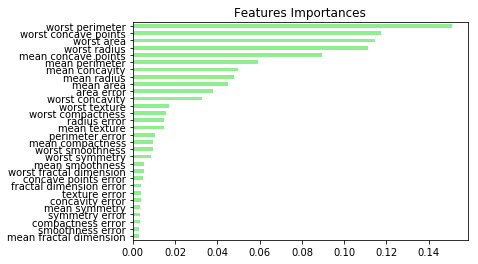

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#split to training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# fit model to training data
rf.fit(X_train,y_train)

# predict on test data
y_pred = rf.predict(X_test)

# get accuracy score
score = accuracy_score(y_test, y_pred)
print("Accuracy: %0.2f [%s]" % (score, 'Random Forest'))

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_,index = data.feature_names)

# Sort importances_rf (note: not easy to do in CV)                              
sorted_importances_rf = importances_rf.sort_values()       

# Make a horizontal bar plot
sorted_importances_rf.plot(kind='barh', color='lightgreen'); 
plt.title('Features Importances');


### **Random Forest Hyperparameters**

The main parameters to adjust when using these methods is `n_estimators` and `max_features`. The best parameter values should always be cross-validated. 

`n_estimators` is the number of trees in the forest. The larger the better (100+), but also the longer it will take to compute. In addition, note that results will stop getting significantly better beyond a critical number of trees. 

`max_features` is the size of the random subsets of features to consider when splitting a node. The lower the greater the reduction of variance, but also the greater the increase in bias. Empirical good default values are max_features=n_features/3 for regression problems, and max_features=sqrt(n_features) for classification tasks (where n_features is the number of features in the data). Generally it should be set to a lower value, as a way of forcing discrepancy between trees. 

Good results are often achieved when setting `max_depth=None` in combination with `min_samples_split=2`, both these settings allow developing full trees. When we increase min_samples_split, each tree in the forest becomes more constrained as it has to consider more samples at each node.

For early stopping set the regularization parameter `min_weight_fraction_leaf` to a sufficiently large value (e.g., 0.05) such that out-of-bag accuracy converges to out-of-sample (k-fold) accuracy.

`class_weight='balanced_subsample'` will help you prevent the trees from misclassifying minority classes.

Note: fitting RF on a PCA of the features may speed up calculations and reduce some overfitting.

___
## **Extremely Randomized Trees**

Extremely randomized trees, or ExtraTrees (ET), are the same as random forests with two slight differences:

1. As in RF's, a random subset of candidate features is used with ET's, but instead of looking for the most discriminative thresholds (the  optimal cut-point for each feature based on information gain), **thresholds are drawn at random for each candidate feature** and the best of these randomly-generated thresholds is picked as the splitting rule. 
    - This threshold (random cut point) is selected from a uniform distribution within the feature's empirical range (in the tree's training set). Then, of all the randomly generated splits, the split that yields the highest score is chosen to split the node. Similar to ordinary RF's, the number of randomly selected features to be considered at each node can be specified.

2. Each tree is trained using the whole training set (rather than a bootstrap sample). 

These differences usually allow to **reduce the variance** of the model a bit more, at the expense of a **slightly greater increase in bias**. ET's are computationally faster than RF's and may give higher performance in presence of many noisy features. Both methods typically perform equally well in the presence of many relevant features.

*Note that in RF's, bootstrap samples are used by default (bootstrap=True) while the default strategy for ET's is to use the whole dataset (bootstrap=False). When using bootstrap sampling the generalization accuracy can be estimated on the left out or out-of-bag samples. This can be enabled by setting oob_score=True.*

___
## **References**

[1] Breiman L, "Random Forests", Machine Learning (2001).
    
[2] https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/

[3] https://scikit-learn.org/stable/modules/ensemble.html#forest

[4] https://en.wikipedia.org/wiki/Random_forest

[5] https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/
